In [1]:
import multiprocessing

start_method = 'forkserver'
try:
    multiprocessing.set_start_method(start_method)
except RuntimeError as e:
    if str(e) != 'context has already been set':
        raise e
    elif multiprocessing.get_start_method() != start_method:
        raise RuntimeWarning(
            'Multiprocessing start_method {} was not set.'
            .format(start_method)
        )
        
N_JOBS = -1  # for sklearn
NTHREAD = 8

In [2]:
import sys
sys.path.append('../Executable')

In [3]:
import random
import time

import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer

/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
import glob
import multiprocessing
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import hdbscan

from IPython.display import display
from preprocessing import LatLongImputer, exp_int, get_word_cnt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, make_scorer
from sklearn.externals import joblib

from eda_plots import (ConditionalProbabilities,
                       plot_count_comparison, plot_interest_pie)
from main import dump_pickle, read_rental_interest, to_min_secs
from outlier_detection import (drop_geo_outl, drop_price_outl, is_geo_outl,
                               is_price_outl)
from sterling_cutler import runXGB

%matplotlib inline

# Autoreload all imported modules at each execution.
%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.4f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
REPORT_IMG_DIR = '../Report-Images/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
DF_TRAIN_PKL = 'cutler_train_df.pkl'
DF_TEST_PKL = 'cutler_test_df.pkl'

# Using built-in 'neg_log_loss' scoring param used for simplicity
# Source code shows exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
train_df = pd.read_json('../Data/train.json')
test_df = pd.read_json('../Data/test.json')

# input errors, 30 bathrooms etc.
test_df['bathrooms'].loc[19671] = 1.5
test_df['bathrooms'].loc[22977] = 2.0
test_df['bathrooms'].loc[63719] = 2.0

# 99.966 percentile
train_df['price'] = train_df['price'].clip(upper=31000)

train_df['logprice'] = np.log(train_df['price'])
test_df['logprice'] = np.log(test_df['price'])

train_df['price_per_bed'] = train_df['price']/train_df['bedrooms']
test_df['price_per_bed'] = test_df['price']/test_df['bedrooms'] 

train_df['room_sum'] = train_df['bedrooms']+train_df['bathrooms'] 
test_df['room_sum'] = test_df['bedrooms']+test_df['bathrooms'] 

train_df['price_per_room'] = train_df['price']/train_df['room_sum']
test_df['price_per_room'] = test_df['price']/test_df['room_sum']

train_df['num_photos'] = train_df['photos'].apply(len)
test_df['num_photos'] = test_df['photos'].apply(len)

train_df['num_features'] = train_df['features'].apply(len)
test_df['num_features'] = test_df['features'].apply(len)

train_df['description_wcnt'] = (
    train_df['description'].apply(lambda x: len(x.split(' '))))
test_df['description_wcnt'] = (
    test_df['description'].apply(lambda x: len(x.split(' '))))

train_df['created'] = pd.to_datetime(train_df['created'])
test_df['created'] = pd.to_datetime(test_df['created'])
train_df['created_year'] = train_df['created'].dt.year
test_df['created_year'] = test_df['created'].dt.year
train_df['created_month'] = train_df['created'].dt.month
test_df['created_month'] = test_df['created'].dt.month
train_df['created_day'] = train_df['created'].dt.day
test_df['created_day'] = test_df['created'].dt.day
train_df['created_hour'] = train_df['created'].dt.hour
test_df['created_hour'] = test_df['created'].dt.hour

train_df['pos'] = (train_df.longitude.round(3).astype(str) + '_'
                   + train_df.latitude.round(3).astype(str))
test_df['pos'] = (test_df.longitude.round(3).astype(str) + '_'
                   + test_df.latitude.round(3).astype(str))
vals = train_df['pos'].value_counts()
train_df = pd.merge(train_df, vals.to_frame('density'), how='left',
                    left_on='pos', right_index=True, copy=False)
test_df = pd.merge(test_df, vals.to_frame('density'), how='left',
                   left_on='pos', right_index=True, copy=False)
test_df['density'] = test_df['density'].fillna(vals.min()).astype(int)

Tremendous performance boost from original, esp. important for CV:
```python
dvals = vals.to_dict()

# 5.12 s ± 82.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
test_df['density'] = test_df['pos'].apply(lambda x: dvals.get(x, vals.min())
```
vs
```python
test_df = pd.merge(test_df, vals.to_frame('density2'), how='left',
                   left_on='pos', right_index=True, copy=False)
# 12.9 ms ± 540 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

test_df['density'] = test_df['density'].fillna(vals.min()).astype(int)
# 440 µs ± 7.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
```

In [80]:
%%timeit

try:
    test_df.drop('density', axis=1, inplace=True)
except ValueError:
    pass
test_df['density'] =  test_df['pos'].apply(lambda x: dvals.get(x, vals.min()))

5.18 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
%%timeit
try:
    test_df.drop('density2', axis=1, inplace=True)
except ValueError:
    pass 
pd.merge(test_df, vals.to_frame('density2'), how='left',
         left_on='pos', right_index=True, copy=False)


27.3 ms ± 697 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
test_df = pd.merge(test_df, vals.to_frame('density2'), how='left',
                   left_on='pos', right_index=True, copy=False)

%timeit test_df['density2'] = test_df['density2'].fillna(vals.min()).astype(int)

assert test_df.density2.equals(test_df.density)
test_df.drop('density2', axis=1, inplace=True)

457 µs ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


What level of granularity is best for density?

In [72]:
train_df = train_df.select(
    lambda x: not (x.startswith('density_') or x.startswith('pos_')), axis=1
)

In [73]:
train_df = train_df.select(
    lambda x: not (x.startswith('density_') or x.startswith('pos_')), axis=1
)
for i in range(1, 5):
    pos = 'pos_' + str(i)
    density = 'density_'+ str(i)
    
    train_df[pos] = (train_df.longitude.round(i).astype(str) + '_'
                     + train_df.latitude.round(i).astype(str))
    vals = train_df[pos].value_counts()
    train_df = pd.merge(train_df, vals.to_frame(density), how='left',
                        left_on=pos, right_index=True, copy=False)
    print('i={}: {} unique'.format(i, len(vals)))

i=1: 44 unique
i=2: 460 unique
i=3: 5152 unique
i=4: 10933 unique


In [8]:

clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

NameError: name 'data' is not defined

Dropped 68 geo-coordinate outliers (0.14%)


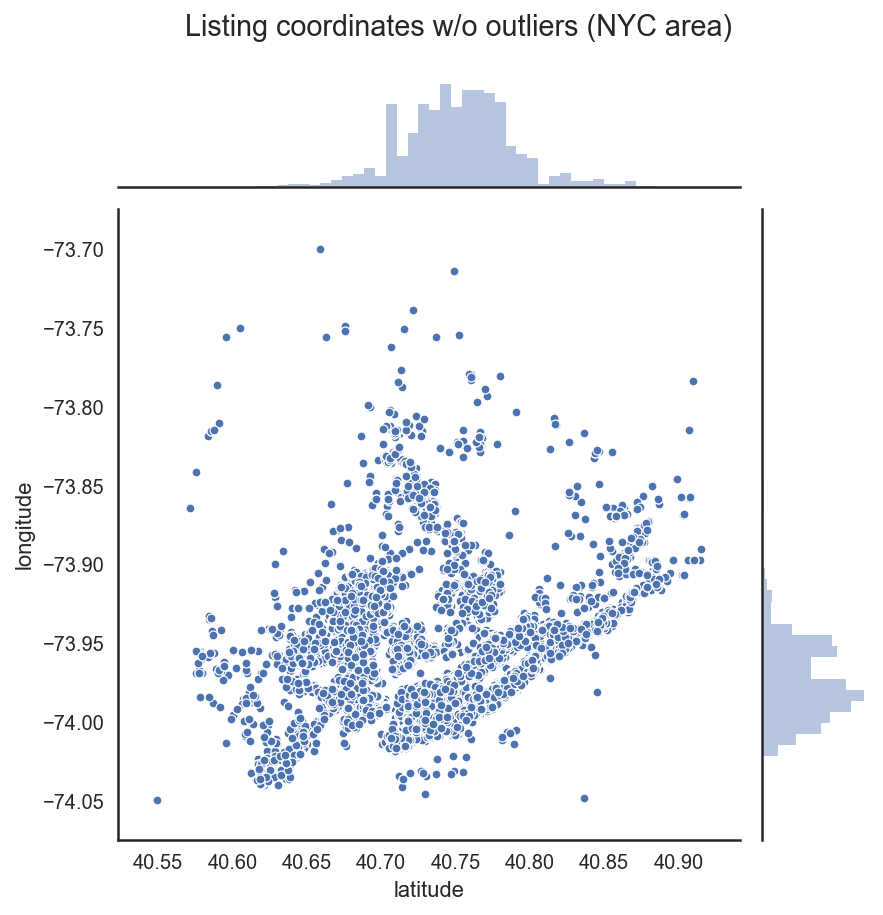

In [9]:
from outlier_detection import drop_geo_outl

data = drop_geo_outl(train_df)
with sns.axes_style('white'):
    sns.jointplot('latitude', 'longitude', data=data, stat_func=None,
                  joint_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.suptitle('Listing coordinates w/o outliers (NYC area)', y=1.05,
             fontsize='x-large')
# plt.savefig(''.join([REPORT_IMG_DIR, '5a-geo-coordinates.png']),
#             dpi=600, bbox_inches='tight')
plt.show()

In [51]:
data = drop_geo_outl(train_df).loc[:, ['latitude', 'longitude']]

clust = hdbscan.HDBSCAN(min_cluster_size=100, 
                        min_samples=100,
                        metric='manhattan',
                        core_dist_n_jobs=-1)
clust.fit(data)

n_clusts = len(np.unique(clust.labels_)) - 1
print(n_clusts)

Dropped 68 geo-coordinate outliers (0.14%)
110


In [105]:
d = dict()
for i, (_, val) in enumerate(train_df.density_1.value_counts().items()):
    d[val] = i

In [107]:
n_clusts = len(train_df.density_1.unique())
color_palette = sns.color_palette('deep', n_clusts+1)
clust_colors = [color_palette[x] for (_, x) in train_df.density_1.replace(d).items()]

In [108]:
x = train_df.density_1.replace(d)

Dropped 68 geo-coordinate outliers (0.14%)


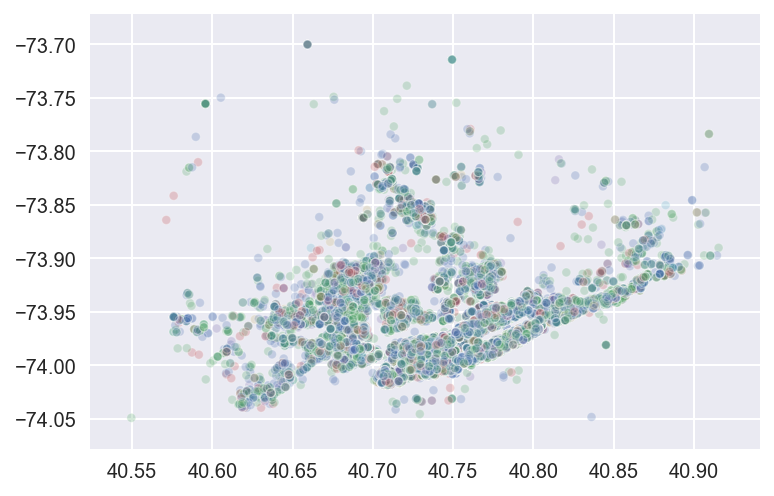

In [112]:
plt.scatter(*drop_geo_outl(train_df).loc[:, ['latitude', 'longitude']].T.values, edgecolor='w', lw=.6, s=20,
            c=clust_colors, alpha=0.25)

# plt.savefig('geo_clusts.png', dpi=600, bbox_inches='tight')

In [115]:
try:
    train_df.interest_level = train_df.interest_level.replace(
        {'high':0, 'medium':1, 'low':2}
    )
except TypeError:
    pass

In [116]:
features_to_use=['bathrooms', 'bedrooms', 'latitude', 'longitude',
                 'price','price_per_bed','price_per_room', 'density',
                 'num_photos', 'num_features', 'description_wcnt',
                 'listing_id', 'created_year', 'created_month', 'created_day',
                 'created_hour', 'density_1', 'density_2', 'density_3',
                 'density_4']

In [117]:
label = train_df.interest_level
dtrain = xgb.DMatrix(train_df.loc[:, features_to_use], label=label)

params = dict(
    eta=0.05,
    max_depth=6,
    eval_metric='mlogloss',
    min_child_weight=1,
    subsample=0.7,
    colsample_bytree=0.7,
    
    missing=-999, nthread=NTHREAD, seed=SEED,
    num_class=3, silent=1,
)

start = time.time()

eval_hist = xgb.cv(params, dtrain, num_boost_round=1000, 
                   stratified=True, early_stopping_rounds=25,
                   metrics='mlogloss', verbose_eval=50,
                   seed=SEED, nfold=3)

end = time.time()
print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))

[0]	train-mlogloss:1.0686+0.000125189	test-mlogloss:1.06917+0.000264775
[50]	train-mlogloss:0.630548+0.00150675	test-mlogloss:0.65333+0.00211616
[100]	train-mlogloss:0.569275+0.00102919	test-mlogloss:0.612105+0.00181341
[150]	train-mlogloss:0.536337+0.000827407	test-mlogloss:0.5985+0.00168573
[200]	train-mlogloss:0.51214+0.00113776	test-mlogloss:0.592108+0.00160215
[250]	train-mlogloss:0.491731+0.00118642	test-mlogloss:0.588747+0.00151067
[300]	train-mlogloss:0.474246+0.000859155	test-mlogloss:0.586411+0.00134402
[350]	train-mlogloss:0.457662+0.00178938	test-mlogloss:0.585067+0.00127416
[400]	train-mlogloss:0.442473+0.00199373	test-mlogloss:0.584123+0.00129715
[450]	train-mlogloss:0.42844+0.00213125	test-mlogloss:0.583876+0.00129503
[500]	train-mlogloss:0.415129+0.00195383	test-mlogloss:0.583944+0.00134107
Runtime: 0min 58s



```
[0]	train-mlogloss:1.06785+0.000172302	test-mlogloss:1.06845+0.000165723
[50]	train-mlogloss:0.629824+0.0013884	test-mlogloss:0.652676+0.00133325
[100]	train-mlogloss:0.56795+0.000772514	test-mlogloss:0.610996+0.0016812
[150]	train-mlogloss:0.53486+0.000902546	test-mlogloss:0.597789+0.00162257
[200]	train-mlogloss:0.51025+0.00126984	test-mlogloss:0.591309+0.00131853
[250]	train-mlogloss:0.490041+0.00160982	test-mlogloss:0.587891+0.0011345
[300]	train-mlogloss:0.471787+0.00152159	test-mlogloss:0.585835+0.00114481
[350]	train-mlogloss:0.455523+0.00174707	test-mlogloss:0.584749+0.00117576
[400]	train-mlogloss:0.440499+0.00183799	test-mlogloss:0.58387+0.0013136
[450]	train-mlogloss:0.426115+0.00144556	test-mlogloss:0.5836+0.00136283
Runtime: 0min 48s

```

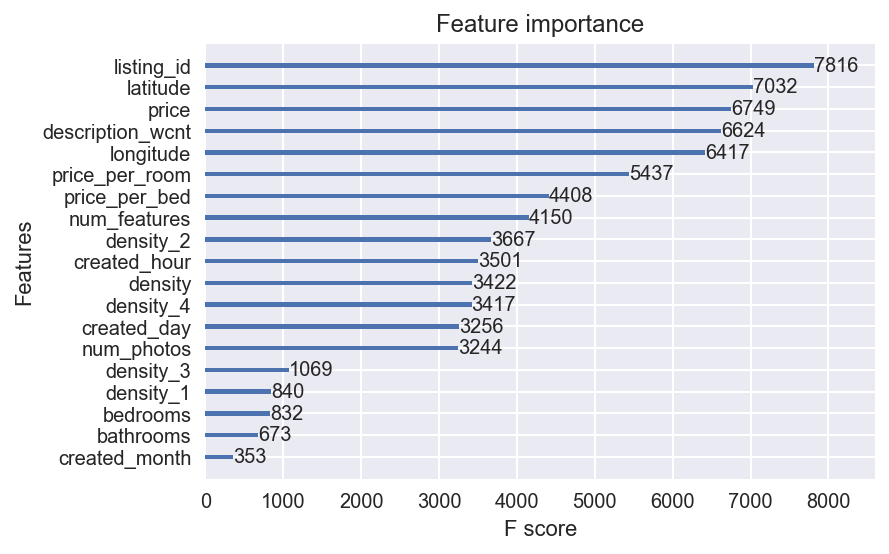

In [82]:
xgb.plot_importance(bst)

In [17]:
index = list(range(train_df.shape[0]))
random.shuffle(index)
a=[np.nan]*len(train_df)
b=[np.nan]*len(train_df)
c=[np.nan]*len(train_df)

for i in range(5):
    building_level = {}
    for j in train_df['manager_id'].values:
        building_level[j] = [0, 0, 0]
    
    test_index = index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
    train_index = list(set(index).difference(test_index))
    
    for j in train_index:
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp['manager_id']][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp['manager_id']][1]+=1
        if temp['interest_level']=='high':
            building_level[temp['manager_id']][2]+=1
            
    for j in test_index:
        temp=train_df.iloc[j]
        if sum(building_level[temp['manager_id']])!=0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
            
train_df['manager_level_low']=a
train_df['manager_level_medium']=b
train_df['manager_level_high']=c

a=[]
b=[]
c=[]
building_level={}
for j in train_df['manager_id'].values:
    building_level[j]=[0,0,0]

for j in range(train_df.shape[0]):
    temp=train_df.iloc[j]
    if temp['interest_level']=='low':
        building_level[temp['manager_id']][0]+=1
    if temp['interest_level']=='medium':
        building_level[temp['manager_id']][1]+=1
    if temp['interest_level']=='high':
        building_level[temp['manager_id']][2]+=1

for i in test_df['manager_id'].values:
    if i not in building_level.keys():
        a.append(np.nan)
        b.append(np.nan)
        c.append(np.nan)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
test_df['manager_level_low']=a
test_df['manager_level_medium']=b
test_df['manager_level_high']=c

features_to_use.append('manager_level_low') 
features_to_use.append('manager_level_medium') 
features_to_use.append('manager_level_high')

categorical = ['display_address', 'manager_id', 'building_id']
for f in categorical:
        if train_df[f].dtype=='object':
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

train_df['features'] = train_df['features'].apply(lambda x: ' '.join(['_'.join(i.split(' ')) for i in x]))
test_df['features'] = test_df['features'].apply(lambda x: ' '.join(['_'.join(i.split(' ')) for i in x]))

tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df['features'])
te_sparse = tfidf.transform(test_df['features'])

train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))

preds, model = runXGB(train_X, train_y, test_X, num_rounds=2000)
out_df = pd.DataFrame(preds)
out_df.columns = ['high', 'medium', 'low']
out_df['listing_id'] = test_df.listing_id.values
# out_df.to_csv('sub69.csv', index=False)

ValueError: Supply a 'c' kwarg or a 'color' kwarg but not both; they differ but their functionalities overlap.

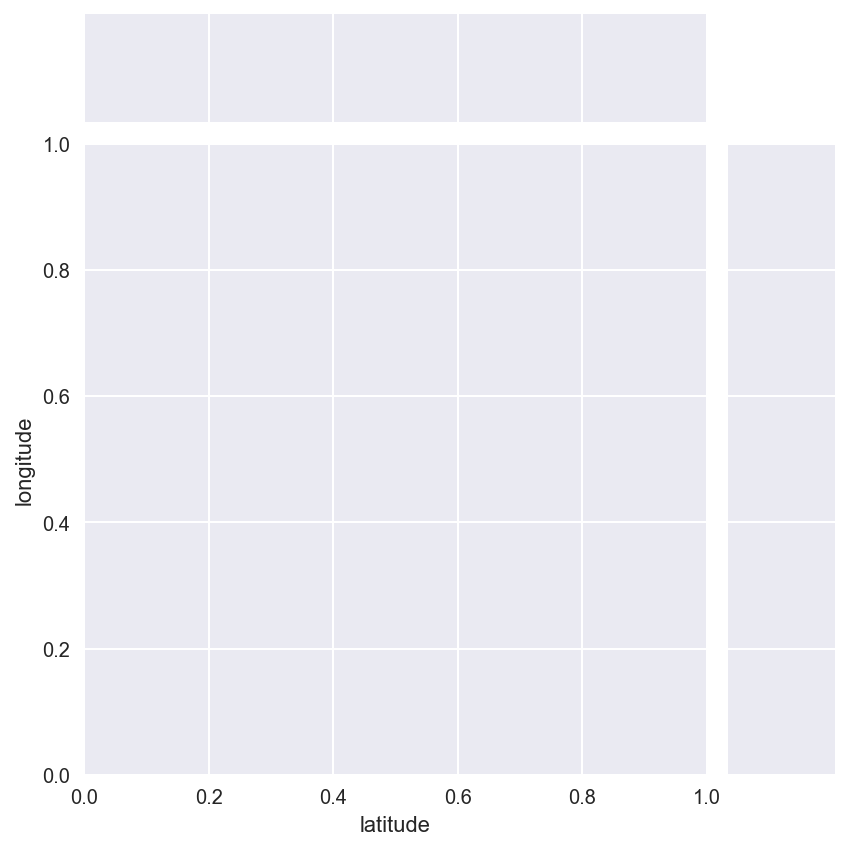

In [53]:
# with sns.axes_style('white'):
sns.jointplot('latitude', 'longitude', data=data, stat_func=None,
              joint_kws=dict(edgecolor='w', lw=.6, s=20, c=clust_member_colors)
)
# plt.savefig('geo_clusts.png', dpi=600, bbox_inches='tight')
plt.show()

In [69]:
vals.sort_index()

-118.3_34.0        1
-71.0_42.2         4
-71.0_42.3         1
-71.1_42.3         4
-71.2_42.3         2
-72.1_41.0         1
-73.2_40.9         1
-73.5_41.0         4
-73.5_42.9         2
-73.7_40.6         1
-73.7_40.7        15
-73.8_40.6        18
-73.8_40.7       286
-73.8_40.8        80
-73.8_40.9         7
-73.8_41.0         1
-73.9_40.6        65
-73.9_40.7      2062
-73.9_40.8      5105
-73.9_40.9       716
-73.9_41.0         2
-73.9_41.1         2
-74.0_40.5         1
-74.0_40.6       584
-74.0_40.7     20999
-74.0_40.8     19345
-74.1_40.6         7
-74.1_40.8         1
-74.2_40.5         3
-74.2_40.6         1
-74.2_40.7         6
-74.2_40.8         2
-74.5_40.5         1
-74.5_40.6         1
-74.6_39.8         1
-74.6_40.1         1
-74.7_40.7         1
-75.2_44.6         1
-75.5_40.0         1
-76.6_43.0         1
-86.2_39.8         1
-87.6_41.8         1
-93.3_44.9         1
0.0_0.0           12
Name: pos1, dtype: int64

In [47]:
drop_geo_outl(train_df)[clust.labels_==-1].density.describe()

Dropped 68 geo-coordinate outliers (0.14%)


count   11974.0000
mean       27.5404
std        29.4896
min         1.0000
25%         5.0000
50%        19.0000
75%        40.0000
max       252.0000
Name: density, dtype: float64